# Analyze vibrational entropy, as computed by CREST / GFN2 across a large molecular test set

This notebook is intended to be used in JupyterLab. YMMV

In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

from scipy import constants

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

We'll read in the combined CSV, including subset name, filename, SMILES, computed entropies, and a variety of descriptors generated by RDKit

In [2]:
df = pd.read_csv("total-entropy.csv")
# drop inf and nan (i.e. some molecules from COD don't have Gasteiger charges)
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
# some vibrational jobs failed, so drop if VibEntropy == 0
df = df[df.VibEntropy != 0]
print(len(df.index))
# 87949 molecules left
#  (technically we should check to make sure all the SMILES are unique!)

87949


In [3]:
# what do we have left?
print(df.columns)
df = df.astype({"NumAtoms": int, "NumBonds": int, "NumRotors": int, "NumMethyl": int, "NumAmine": int, "NumHydroxyl": int, "HDonors": int, "HAcceptors": int, "RingCount": int, "NumAromaticRings": int})
df.describe()

Index(['Category', 'File', 'SMILES', 'ConfEntropy', 'VibEntropy', 'RotEntropy',
       'TransEntropy', 'NumAtoms', 'NumBonds', 'ExactMolWt', 'Volume',
       'NumRotors', 'NumMethyl', 'NumAmine', 'NumHydroxyl', 'HDonors',
       'HAcceptors', 'RingCount', 'NumAromaticRings', 'MaxAbsPartialChg',
       'MinAbsPartialChg', 'MaxPartialChg', 'MinPartialChg', 'TPSA',
       'LabuteASA', 'MolMR', 'MolLogP', 'EState_VSA1', 'EState_VSA2',
       'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'HallKierAlpha', 'BertzCT',
       'BalabanJ', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'FractionCSP3',
       'Asphericity', 'Eccentricity', 'InertialShapeFactor',
       'RadiusOfGyration', 'SpherocityIndex', 'ConfUnder1', 'ConfUnder2',
       'ConfUnder3', 'ConfUnder4', 'ConfUnder5', 'ConfUnder6', 'ECFP4'],
      dtype='object')


,ConfEntropy,VibEntropy,RotEntropy,TransEntropy,NumAtoms,NumBonds,ExactMolWt,Volume,NumRotors,NumMethyl,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,ConfUnder1,ConfUnder2,ConfUnder3,ConfUnder4,ConfUnder5,ConfUnder6
count,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,...,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000
mean,34.470609,408.341162,149.862348,183.312216,29.602554,32.571888,415.299401,408.558975,4.686477,2.334194,...,0.945626,0.000880,4.330246,0.175516,7.462632,19.619348,37.052951,58.713391,83.697541,111.179104
std,11.914549,136.865085,7.973041,3.887599,8.550787,9.932608,115.758279,109.989251,2.658016,2.104448,...,0.059728,0.001623,0.963279,0.136158,11.653509,31.682838,59.155031,92.113083,129.965145,170.548217
min,0.004000,29.836104,96.713160,159.339272,4.000000,3.000000,58.078250,66.904000,0.000000,0.000000,...,0.169475,0.000013,1.231888,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27.056000,316.105384,146.201512,181.447528,24.000000,26.000000,342.081143,338.816000,3.000000,1.000000,...,0.921586,0.000316,3.666778,0.081280,2.000000,4.000000,6.000000,8.000000,10.000000,11.000000
50%,36.087000,422.918720,151.636528,184.217336,31.000000,34.000000,427.235873,422.952000,4.000000,2.000000,...,0.966219,0.000537,4.317650,0.142056,4.000000,10.000000,18.000000,27.000000,37.000000,47.000000
75%,43.026000,491.992376,154.895864,185.660816,35.000000,38.000000,480.105647,472.392000,6.000000,3.000000,...,0.988091,0.000908,4.969053,0.234509,9.000000,23.000000,45.000000,72.000000,105.000000,142.000000
max,68.287000,1659.328376,196.346752,203.702224,131.000000,192.000000,2039.240573,1410.992000,20.000000,26.000000,...,0.999999,0.162280,12.050900,0.989008,495.000000,981.000000,1403.000000,1822.000000,2410.000000,3693.000000


The goal is to understand how the computed **vibrational** entropies change with molecular structure.

Since larger molecules likely have more vibrational modes (3N-6) and lower-energy modes (i.e., they're bigger) - let's start with simple models comparing ExactMolt and NumAtoms 

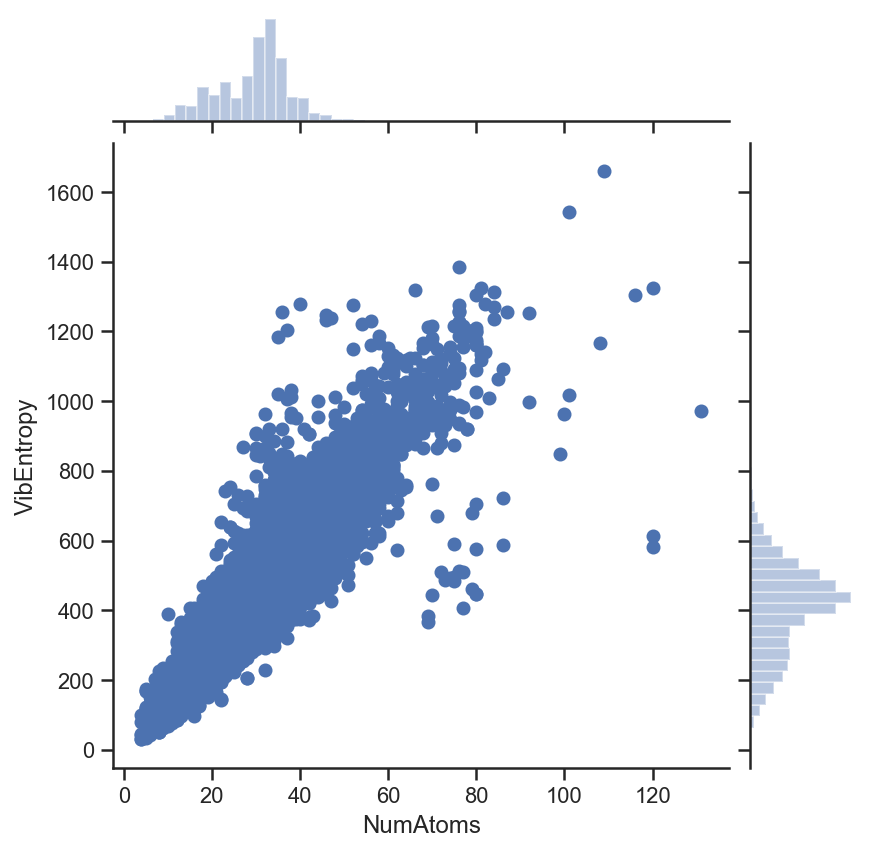

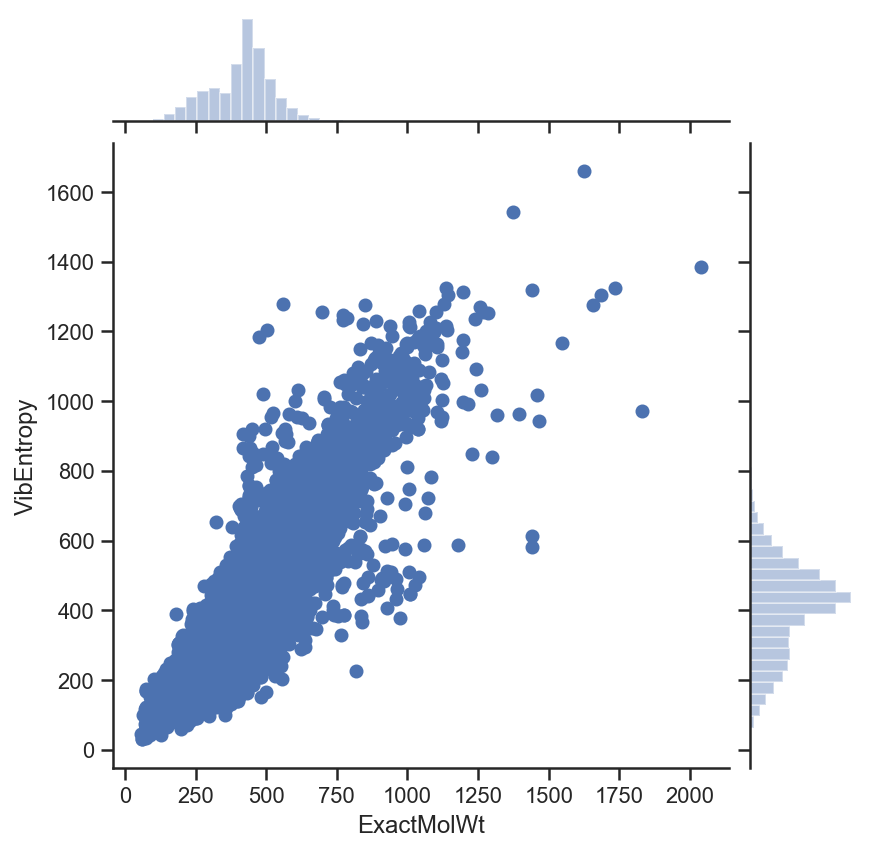

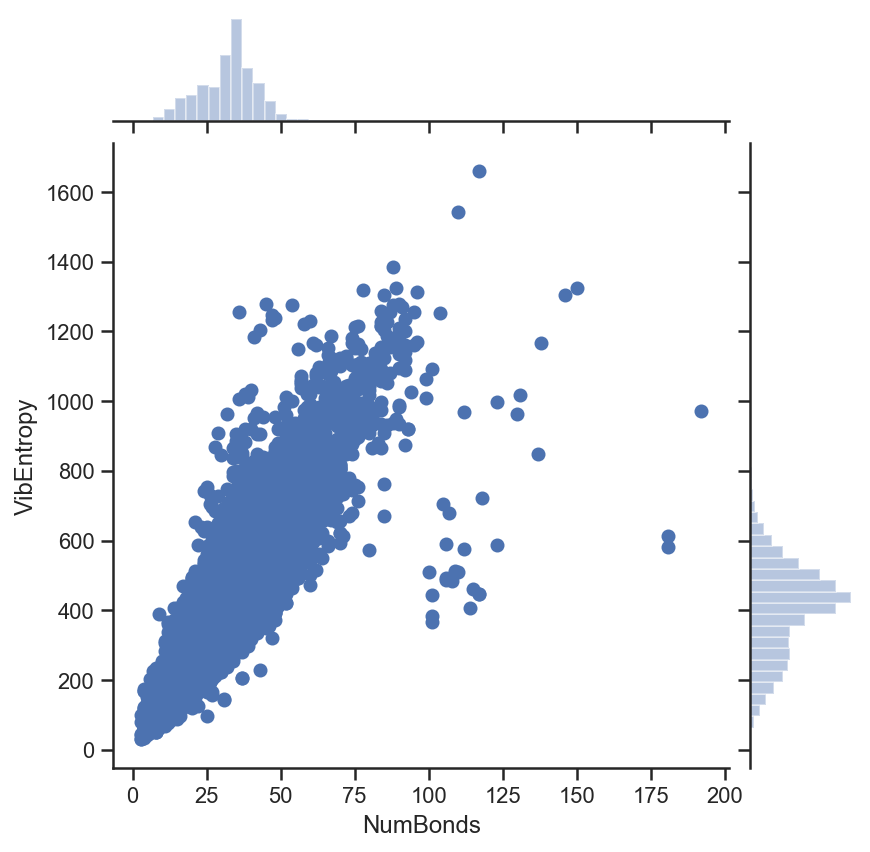

In [5]:
sns.jointplot(x="NumAtoms", y="VibEntropy", data=df)
sns.jointplot(x="ExactMolWt", y="VibEntropy", data=df)
sns.jointplot(x="NumBonds", y="VibEntropy", data=df)

In [6]:
import sklearn
from sklearn.metrics import mean_absolute_error

lm = ols('VibEntropy~NumAtoms', data=df).fit()
print('mean absolute error (NumAtoms):', mean_absolute_error(df['VibEntropy'], lm.fittedvalues))

lm = ols('VibEntropy~ExactMolWt', data=df).fit()
print('mean absolute error (ExactMolWt):', mean_absolute_error(df['VibEntropy'], lm.fittedvalues))

lm = ols('VibEntropy~NumBonds', data=df).fit()
print('mean absolute error (NumBonds):', mean_absolute_error(df['VibEntropy'], lm.fittedvalues))

mean absolute error (NumAtoms): 33.753352940647574
mean absolute error (ExactMolWt): 34.45498559656018
mean absolute error (NumBonds): 42.53914927271583


In [7]:
lm = ols('VibEntropy~ExactMolWt+NumAtoms+NumBonds', data=df).fit()
print('mean absolute error (Combined):', mean_absolute_error(df['VibEntropy'], lm.fittedvalues))

mean absolute error (Combined): 21.819224085733865


Nice, that's a solid decrease in error - now 21.8 J/mol•K. At 300K, that's an error of ~1.5 kcal/mol - let's see if we can do better with QSAR

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

In [13]:
formula = 'VibEntropy~' + '+'.join(df.columns[7:19]) + '+' + '+'.join(df.columns[23:27]) + '+' + '+'.join(df.columns[32:-7])
print(formula)

VibEntropy~NumAtoms+NumBonds+ExactMolWt+Volume+NumRotors+NumMethyl+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+TPSA+LabuteASA+MolMR+MolLogP+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex


In [14]:
max_mae = 100.0
best_alpha = 0
for a in range(100):
    lm = ols(formula, df).fit_regularized(alpha=float(a)/100.0)
    mae = mean_absolute_error(df['VibEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = float(a)/100.0
        max_mae = mae
        print('best so far', best_alpha, max_mae)

lm = ols(formula,df).fit_regularized(alpha=best_alpha)
print(lm.params)

best so far 0.0 20.626645070405715
best so far 0.03 20.587791145434245
best so far 0.04 20.54313664062473
best so far 0.05 20.498796575318345
best so far 0.06 20.454657718370044
best so far 0.07 20.428372593842145
best so far 0.08 20.368523215900883
best so far 0.09 20.32653944210067
best so far 0.1 20.292304279161577
best so far 0.11 20.25144316916704
best so far 0.12 20.21136681664805
best so far 0.13 20.192340007410035
best so far 0.14 20.133892383051034
best so far 0.15 20.096101781578984
best so far 0.22 20.07441498708497
best so far 0.23 20.042398211039522
best so far 0.24 20.01125135914827
best so far 0.25 19.98103998284784
best so far 0.26 19.951691868646755
best so far 0.27 19.922812069705802
best so far 0.28 19.89509698020259
best so far 0.32 19.79471260070602
best so far 0.33 19.771544263035505
best so far 0.34 19.749156716958748
best so far 0.35 19.715392085886783
best so far 0.36 19.688603047508717
best so far 0.37 19.664064603120494
best so far 0.38 19.640642678858114
bes

It turns out that a bunch of these are cross-correlated, but LASSO drops the ExactMolWt and NumBonds in favor of NumAtoms, and picks up NumMethyl and RingCount (i.e., more rings = less entropy). What follows is a hand-tuned model after selecting from the factors with large scores from LASSO:

In [15]:
lm = ols('VibEntropy~NumAtoms+NumMethyl+RingCount', data=df).fit()
print(lm.summary())
print('mean absolute error (Combined):', mean_absolute_error(df['VibEntropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:             VibEntropy   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 8.123e+05
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:42:24   Log-Likelihood:            -4.0978e+05
No. Observations:               87949   AIC:                         8.196e+05
Df Residuals:                   87945   BIC:                         8.196e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.2200      0.313   -169.864      0.0

So we've dropped the error to ~16.8 J/mol•K, about half our original error - corresponding to ~1.2 kcal/mol at 300K. 